In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append("../")
from ad_utils import *
from sklearn.model_selection import train_test_split


cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(normal_data, normal_label, test_size=0.2, random_state=42, shuffle=True)
X_train_faulty, X_test_faulty, y_train_faulty, y_test_faulty = train_test_split(faulty_data, faulty_label, test_size=0.2, random_state=42, shuffle=True)

NVIDIA A30
(872, 4500, 14) (872,)


# Time GAN

In [2]:
# Enhanced chunking for long sequences (4500 timesteps)
def chunk_sequences_enhanced(data, chunk_size=200, overlap=50):
    """
    Enhanced chunking optimized for long sensor sequences
    """
    n_samples, seq_len, n_features = data.shape
    chunks = []
    
    for sample in data:
        # Create chunks with larger size and more overlap for 4500 timestep sequences
        for start in range(0, seq_len - chunk_size + 1, chunk_size - overlap):
            end = start + chunk_size
            if end <= seq_len:
                chunks.append(sample[start:end])
    
    return np.array(chunks)

class Embedder(nn.Module):
    """Optimized Embedding network for long sensor sequences."""
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Optimized conv1d for sensor data patterns
        self.conv1d = nn.Conv1d(input_dim, hidden_dim // 2, kernel_size=7, padding=3)
        
        # Efficient LSTM for long sequences
        self.lstm = nn.LSTM(
            input_size=hidden_dim // 2, 
            hidden_size=hidden_dim // 2,  # Reduced for memory efficiency
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Simplified attention for sensor data
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim, 
            num_heads=2,  # Reduced for efficiency
            dropout=0.1,
            batch_first=True
        )
        
        # Projection layer
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, X):
        """Forward pass optimized for sensor data."""
        # Conv1D for sensor pattern extraction
        X_conv = self.conv1d(X.transpose(1, 2)).transpose(1, 2)
        
        # LSTM for temporal dynamics
        H_lstm, _ = self.lstm(X_conv)
        
        # Attention for important patterns
        H_att, _ = self.attention(H_lstm, H_lstm, H_lstm)
        
        # Final projection
        H = self.projection(H_att)
        return H

class Recovery(nn.Module):
    """Optimized Recovery network for sensor data reconstruction."""
    def __init__(self, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        # Efficient LSTM for reconstruction
        self.lstm = nn.LSTM(
            input_size=hidden_dim, 
            hidden_size=hidden_dim // 2,  # Reduced complexity
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Simplified reconstruction layers
        self.recovery_layers = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, output_dim),
            nn.Tanh()
        )
        
    def forward(self, H):
        """Forward pass for sensor data recovery."""
        # LSTM processing
        H_lstm, _ = self.lstm(H)
        
        # Direct reconstruction for efficiency
        X_tilde = self.recovery_layers(H_lstm)
        return X_tilde

class Generator(nn.Module):
    """Optimized Generator for sensor time series."""
    def __init__(self, z_dim, hidden_dim, num_layers):
        super().__init__()
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Noise transformation for sensor data
        self.noise_transform = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(inplace=True)
        )
        
        # Efficient LSTM generation
        self.lstm = nn.LSTM(
            input_size=hidden_dim, 
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Sensor-specific generation layers
        self.generation_layers = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )
        
    def forward(self, Z):
        """Forward pass optimized for sensor generation."""
        # Transform noise
        Z_transformed = self.noise_transform(Z)
        
        # LSTM generation
        H_lstm, _ = self.lstm(Z_transformed)
        
        # Final generation
        H_hat = self.generation_layers(H_lstm)
        return H_hat

class Supervisor(nn.Module):
    """Optimized Supervisor for sensor temporal prediction."""
    def __init__(self, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Simplified LSTM for supervision
        self.lstm = nn.LSTM(
            input_size=hidden_dim, 
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Direct prediction head
        self.prediction_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )
        
    def forward(self, H):
        """Forward pass for sensor supervision."""
        # LSTM processing
        H_lstm, _ = self.lstm(H)
        
        # Prediction
        H_hat_supervise = self.prediction_head(H_lstm)
        return H_hat_supervise

class Discriminator(nn.Module):
    """Optimized Discriminator for sensor data."""
    def __init__(self, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Multi-scale conv for sensor patterns
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=k, padding=k//2)
            for k in [3, 7, 15]  # Different sensor pattern scales
        ])
        
        # Efficient LSTM discriminator
        self.lstm = nn.LSTM(
            input_size=hidden_dim * 3,
            hidden_size=hidden_dim,
            num_layers=max(1, num_layers-1),
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Simplified discrimination head
        self.discriminator_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, H):
        """Forward pass for sensor discrimination."""
        # Multi-scale convolution
        H_transpose = H.transpose(1, 2)
        multi_scale_features = []
        
        for conv in self.conv_layers:
            conv_out = torch.relu(conv(H_transpose))
            multi_scale_features.append(conv_out)
        
        # Concatenate features
        H_multi = torch.cat(multi_scale_features, dim=1).transpose(1, 2)
        
        # LSTM processing
        H_lstm, _ = self.lstm(H_multi)
        
        # Final discrimination
        Y = self.discriminator_head(H_lstm)
        return Y

# Optimized training function for sensor data
def train_timegan_enhanced(data, seq_len, batch_size, model_params, train_params):
    """
    Optimized TimeGAN training for sensor data
    """
    # Optimized chunking for 4500 timesteps
    chunk_size = seq_len
    print(f"Chunking sequences into size {chunk_size}...")
    chunked_data = chunk_sequences_enhanced(data, chunk_size=chunk_size, overlap=50)
    print(f"Created {len(chunked_data)} chunks from {len(data)} original sequences")
    
    # Model parameters
    input_dim = model_params['input_dim']
    hidden_dim = model_params['hidden_units']
    num_layers = model_params['num_layers']
    z_dim = model_params['z_dim']
    
    # Training parameters
    epochs = train_params['epochs']
    learning_rate = train_params['learning_rate']
    
    # Dataset and loader
    data_tensor = torch.tensor(chunked_data, dtype=torch.float32)
    dataset = TensorDataset(data_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Initialize models
    embedder = Embedder(input_dim, hidden_dim, num_layers).to(device)
    recovery = Recovery(hidden_dim, input_dim, num_layers).to(device)
    generator = Generator(z_dim, hidden_dim, num_layers).to(device)
    supervisor = Supervisor(hidden_dim, num_layers).to(device)
    discriminator = Discriminator(hidden_dim, num_layers).to(device)
    
    # Optimized weight initialization
    def init_weights(m):
        if isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    nn.init.constant_(param.data, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    for model in [embedder, recovery, generator, supervisor, discriminator]:
        model.apply(init_weights)
    
    # Balanced optimizers for sensor data
    e_optimizer = optim.Adam(
        list(embedder.parameters()) + list(recovery.parameters()), 
        lr=learning_rate, betas=(0.5, 0.999)
    )
    g_optimizer = optim.Adam(
        list(generator.parameters()) + list(supervisor.parameters()), 
        lr=learning_rate, betas=(0.5, 0.999)
    )
    d_optimizer = optim.Adam(
        discriminator.parameters(), 
        lr=learning_rate * 0.5, betas=(0.5, 0.999)
    )
    
    print('Starting Optimized TimeGAN Training for Sensor Data...')
    
    # Training history
    history = {
        'embedding_loss': [],
        'generator_loss': [],
        'discriminator_loss': []
    }
    
    for epoch in range(epochs):
        epoch_e_loss = 0
        epoch_g_loss = 0
        epoch_d_loss = 0
        
        for batch_idx, (X_mb,) in enumerate(dataloader):
            X_mb = X_mb.to(device)
            batch_size_actual = X_mb.shape[0]
            
            # Embedding training
            embedder.train()
            recovery.train()
            
            H = embedder(X_mb)
            X_tilde = recovery(H)
            
            e_loss = torch.mean(torch.abs(X_mb - X_tilde))
            
            e_optimizer.zero_grad()
            e_loss.backward()
            torch.nn.utils.clip_grad_norm_(
                list(embedder.parameters()) + list(recovery.parameters()), 
                max_norm=1.0
            )
            e_optimizer.step()
            
            epoch_e_loss += e_loss.item()
            
            # Generator and Discriminator training (every 2 iterations)
            if batch_idx % 2 == 0:
                
                # Generator training
                generator.train()
                supervisor.train()
                
                Z_mb = torch.randn(batch_size_actual, seq_len, z_dim).to(device)
                H_hat = generator(Z_mb)
                H_hat_supervise = supervisor(H_hat)
                X_hat = recovery(H_hat)
                
                with torch.no_grad():
                    H_real = embedder(X_mb)
                
                Y_fake = discriminator(H_hat)
                
                # Generator loss components
                adv_loss = torch.mean((Y_fake - 1) ** 2)
                
                if H_real.size(1) > 1:
                    sup_loss = torch.mean(torch.abs(H_real[:, 1:, :] - H_hat_supervise[:, :-1, :]))
                else:
                    sup_loss = torch.tensor(0.0, device=device)
                
                recon_loss = torch.mean(torch.abs(X_mb - X_hat))
                
                g_loss = adv_loss + sup_loss + 0.1 * recon_loss
                
                g_optimizer.zero_grad()
                g_loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    list(generator.parameters()) + list(supervisor.parameters()), 
                    max_norm=1.0
                )
                g_optimizer.step()
                
                epoch_g_loss += g_loss.item()
                
                # Discriminator training
                discriminator.train()
                
                Z_mb_d = torch.randn(batch_size_actual, seq_len, z_dim).to(device)
                with torch.no_grad():
                    H_hat_d = generator(Z_mb_d)
                    H_real_d = embedder(X_mb)
                
                Y_fake_d = discriminator(H_hat_d.detach())
                Y_real_d = discriminator(H_real_d)
                
                d_loss = (torch.mean((Y_real_d - 1) ** 2) + torch.mean(Y_fake_d ** 2)) / 2
                
                d_optimizer.zero_grad()
                d_loss.backward()
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
                d_optimizer.step()
                
                epoch_d_loss += d_loss.item()
        
        # Calculate averages
        num_batches = len(dataloader)
        g_d_batches = num_batches // 2
        
        avg_e_loss = epoch_e_loss / num_batches
        avg_g_loss = epoch_g_loss / g_d_batches if g_d_batches > 0 else 0
        avg_d_loss = epoch_d_loss / g_d_batches if g_d_batches > 0 else 0
        
        history['embedding_loss'].append(avg_e_loss)
        history['generator_loss'].append(avg_g_loss)
        history['discriminator_loss'].append(avg_d_loss)
        
        # Progress reporting
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch+1}/{epochs}: E_Loss: {avg_e_loss:.4f}, '
                  f'G_Loss: {avg_g_loss:.4f}, D_Loss: {avg_d_loss:.4f}')
    
    print('TimeGAN training completed!')
    
    return {
        'embedder': embedder,
        'recovery': recovery,
        'generator': generator,
        'supervisor': supervisor,
        'discriminator': discriminator,
        'chunk_size': chunk_size,
        'original_seq_len': data.shape[1],
        'history': history
    }

# Optimized generation function
def generate_timegan_samples_enhanced(model, n_samples, seq_len, z_dim):
    """
    Generate synthetic samples optimized for sensor data
    """
    generator = model['generator']
    supervisor = model['supervisor']
    recovery = model['recovery']
    
    generator.eval()
    supervisor.eval()
    recovery.eval()
    
    generated_samples = []
    batch_size = 32  # Smaller batches for memory efficiency
    
    with torch.no_grad():
        for i in range(0, n_samples, batch_size):
            current_batch_size = min(batch_size, n_samples - i)
            
            Z = torch.randn(current_batch_size, seq_len, z_dim).to(device)
            
            H_hat = generator(Z)
            H_hat = supervisor(H_hat)
            X_hat = recovery(H_hat)
            
            generated_samples.append(X_hat.cpu().numpy())
    
    return np.concatenate(generated_samples, axis=0)

def reconstruct_full_sequences_enhanced(chunks, original_length=4500, chunk_size=200, overlap=50):
    """
    Optimized sequence reconstruction for sensor data
    """
    step_size = chunk_size - overlap
    chunks_needed = (original_length - overlap) // step_size + 1
    
    n_full_sequences = len(chunks) // chunks_needed
    full_sequences = []
    
    for i in range(n_full_sequences):
        start_idx = i * chunks_needed
        end_idx = start_idx + min(chunks_needed, len(chunks) - start_idx)
        sequence_chunks = chunks[start_idx:end_idx]
        
        # Simple reconstruction for efficiency
        reconstructed = np.zeros((original_length, sequence_chunks.shape[2]))
        weights = np.zeros(original_length)
        
        for j, chunk in enumerate(sequence_chunks):
            pos = j * step_size
            end_pos = min(pos + chunk_size, original_length)
            chunk_len = end_pos - pos
            
            if chunk_len > 0:
                reconstructed[pos:end_pos] += chunk[:chunk_len]
                weights[pos:end_pos] += 1
        
        weights[weights == 0] = 1
        reconstructed = reconstructed / weights[:, np.newaxis]
        full_sequences.append(reconstructed)
    
    return np.array(full_sequences)

In [3]:
class Generator(nn.Module):
    """Optimized Generator for sensor time series."""
    def __init__(self, z_dim, hidden_dim, num_layers):
        super().__init__()
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Noise transformation for sensor data
        self.noise_transform = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(inplace=True)
        )
        
        # Efficient LSTM generation - FIXED: use hidden_size instead of hidden_dim
        self.lstm = nn.LSTM(
            input_size=hidden_dim, 
            hidden_size=hidden_dim,  # Changed from hidden_dim=hidden_dim
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Sensor-specific generation layers
        self.generation_layers = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )
        
    def forward(self, Z):
        """Forward pass optimized for sensor generation."""
        # Transform noise
        Z_transformed = self.noise_transform(Z)
        
        # LSTM generation
        H_lstm, _ = self.lstm(Z_transformed)
        
        # Final generation
        H_hat = self.generation_layers(H_lstm)
        return H_hat

class Supervisor(nn.Module):
    """Optimized Supervisor for sensor temporal prediction."""
    def __init__(self, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Simplified LSTM for supervision - FIXED: use hidden_size instead of hidden_dim
        self.lstm = nn.LSTM(
            input_size=hidden_dim, 
            hidden_size=hidden_dim,  # Changed from hidden_dim=hidden_dim
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Direct prediction head
        self.prediction_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )
        
    def forward(self, H):
        """Forward pass for sensor supervision."""
        # LSTM processing
        H_lstm, _ = self.lstm(H)
        
        # Prediction
        H_hat_supervise = self.prediction_head(H_lstm)
        return H_hat_supervise

class Discriminator(nn.Module):
    """Optimized Discriminator for sensor data."""
    def __init__(self, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Multi-scale conv for sensor patterns
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=k, padding=k//2)
            for k in [3, 7, 15]  # Different sensor pattern scales
        ])
        
        # Efficient LSTM discriminator - FIXED: use hidden_size instead of hidden_dim
        self.lstm = nn.LSTM(
            input_size=hidden_dim * 3,
            hidden_size=hidden_dim,  # Changed from hidden_dim=hidden_dim
            num_layers=max(1, num_layers-1),
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Simplified discrimination head
        self.discriminator_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, H):
        """Forward pass for sensor discrimination."""
        # Multi-scale convolution
        H_transpose = H.transpose(1, 2)
        multi_scale_features = []
        
        for conv in self.conv_layers:
            conv_out = torch.relu(conv(H_transpose))
            multi_scale_features.append(conv_out)
        
        # Concatenate features
        H_multi = torch.cat(multi_scale_features, dim=1).transpose(1, 2)
        
        # LSTM processing
        H_lstm, _ = self.lstm(H_multi)
        
        # Final discrimination
        Y = self.discriminator_head(H_lstm)
        return Y
    
def train_timegan_enhanced(data, seq_len, batch_size, model_params, train_params):
    """
    Optimized TimeGAN training for sensor data
    """
    # Optimized chunking for 4500 timesteps
    chunk_size = seq_len
    print(f"Chunking sequences into size {chunk_size}...")
    chunked_data = chunk_sequences_enhanced(data, chunk_size=chunk_size, overlap=50)
    print(f"Created {len(chunked_data)} chunks from {len(data)} original sequences")
    
    # Model parameters
    input_dim = model_params['input_dim']
    hidden_dim = model_params['hidden_units']
    num_layers = model_params['num_layers']
    z_dim = model_params['z_dim']
    
    # Training parameters
    epochs = train_params['epochs']
    learning_rate = train_params['learning_rate']
    
    # Dataset and loader
    data_tensor = torch.tensor(chunked_data, dtype=torch.float32)
    dataset = TensorDataset(data_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Initialize models
    embedder = Embedder(input_dim, hidden_dim, num_layers).to(device)
    recovery = Recovery(hidden_dim, input_dim, num_layers).to(device)
    generator = Generator(z_dim, hidden_dim, num_layers).to(device)
    supervisor = Supervisor(hidden_dim, num_layers).to(device)
    discriminator = Discriminator(hidden_dim, num_layers).to(device)
    
    # Optimized weight initialization
    def init_weights(m):
        if isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    nn.init.constant_(param.data, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    for model in [embedder, recovery, generator, supervisor, discriminator]:
        model.apply(init_weights)
    
    # Balanced optimizers for sensor data
    e_optimizer = optim.Adam(
        list(embedder.parameters()) + list(recovery.parameters()), 
        lr=learning_rate, betas=(0.5, 0.999)
    )
    g_optimizer = optim.Adam(
        list(generator.parameters()) + list(supervisor.parameters()), 
        lr=learning_rate, betas=(0.5, 0.999)
    )
    d_optimizer = optim.Adam(
        discriminator.parameters(), 
        lr=learning_rate * 0.5, betas=(0.5, 0.999)
    )
    
    print('Starting Optimized TimeGAN Training for Sensor Data...')
    
    # Training history - FIXED: added quality_scores
    history = {
        'embedding_loss': [],
        'generator_loss': [],
        'discriminator_loss': [],
        'quality_scores': []  # Added this missing key
    }
    
    for epoch in range(epochs):
        epoch_e_loss = 0
        epoch_g_loss = 0
        epoch_d_loss = 0
        
        for batch_idx, (X_mb,) in enumerate(dataloader):
            X_mb = X_mb.to(device)
            batch_size_actual = X_mb.shape[0]
            
            # Embedding training
            embedder.train()
            recovery.train()
            
            H = embedder(X_mb)
            X_tilde = recovery(H)
            
            e_loss = torch.mean(torch.abs(X_mb - X_tilde))
            
            e_optimizer.zero_grad()
            e_loss.backward()
            torch.nn.utils.clip_grad_norm_(
                list(embedder.parameters()) + list(recovery.parameters()), 
                max_norm=1.0
            )
            e_optimizer.step()
            
            epoch_e_loss += e_loss.item()
            
            # Generator and Discriminator training (every 2 iterations)
            if batch_idx % 2 == 0:
                
                # Generator training
                generator.train()
                supervisor.train()
                
                Z_mb = torch.randn(batch_size_actual, seq_len, z_dim).to(device)
                H_hat = generator(Z_mb)
                H_hat_supervise = supervisor(H_hat)
                X_hat = recovery(H_hat)
                
                with torch.no_grad():
                    H_real = embedder(X_mb)
                
                Y_fake = discriminator(H_hat)
                
                # Generator loss components
                adv_loss = torch.mean((Y_fake - 1) ** 2)
                
                if H_real.size(1) > 1:
                    sup_loss = torch.mean(torch.abs(H_real[:, 1:, :] - H_hat_supervise[:, :-1, :]))
                else:
                    sup_loss = torch.tensor(0.0, device=device)
                
                recon_loss = torch.mean(torch.abs(X_mb - X_hat))
                
                g_loss = adv_loss + sup_loss + 0.1 * recon_loss
                
                g_optimizer.zero_grad()
                g_loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    list(generator.parameters()) + list(supervisor.parameters()), 
                    max_norm=1.0
                )
                g_optimizer.step()
                
                epoch_g_loss += g_loss.item()
                
                # Discriminator training
                discriminator.train()
                
                Z_mb_d = torch.randn(batch_size_actual, seq_len, z_dim).to(device)
                with torch.no_grad():
                    H_hat_d = generator(Z_mb_d)
                    H_real_d = embedder(X_mb)
                
                Y_fake_d = discriminator(H_hat_d.detach())
                Y_real_d = discriminator(H_real_d)
                
                d_loss = (torch.mean((Y_real_d - 1) ** 2) + torch.mean(Y_fake_d ** 2)) / 2
                
                d_optimizer.zero_grad()
                d_loss.backward()
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
                d_optimizer.step()
                
                epoch_d_loss += d_loss.item()
        
        # Calculate averages
        num_batches = len(dataloader)
        g_d_batches = num_batches // 2
        
        avg_e_loss = epoch_e_loss / num_batches
        avg_g_loss = epoch_g_loss / g_d_batches if g_d_batches > 0 else 0
        avg_d_loss = epoch_d_loss / g_d_batches if g_d_batches > 0 else 0
        
        history['embedding_loss'].append(avg_e_loss)
        history['generator_loss'].append(avg_g_loss)
        history['discriminator_loss'].append(avg_d_loss)
        
        # Calculate quality score every 10 epochs
        if epoch % 10 == 0:
            with torch.no_grad():
                # Generate small sample for quality assessment
                Z_test = torch.randn(min(32, len(chunked_data)), seq_len, z_dim).to(device)
                generator.eval()
                supervisor.eval()
                recovery.eval()
                
                H_hat_test = generator(Z_test)
                H_hat_test = supervisor(H_hat_test)
                X_hat_test = recovery(H_hat_test).cpu().numpy()
                
                # Simple quality metric based on reconstruction
                real_sample = chunked_data[:len(X_hat_test)]
                quality_score = 1.0 / (1.0 + np.mean(np.abs(real_sample - X_hat_test)))
                history['quality_scores'].append(quality_score)
        
        # Progress reporting
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch+1}/{epochs}: E_Loss: {avg_e_loss:.4f}, '
                  f'G_Loss: {avg_g_loss:.4f}, D_Loss: {avg_d_loss:.4f}')
    
    print('TimeGAN training completed!')
    
    return {
        'embedder': embedder,
        'recovery': recovery,
        'generator': generator,
        'supervisor': supervisor,
        'discriminator': discriminator,
        'chunk_size': chunk_size,
        'original_seq_len': data.shape[1],
        'history': history
    }

# Train, and generate

Enhanced TimeGAN Configuration for Anomaly Detection:
Chunk Size: 150 (better temporal context)
Hidden Dimension: 64 (enhanced representation)
Number of Layers: 3 (deeper networks)
Latent Dimension: 28 (richer noise space)
Batch Size: 32 (optimized for stability)
Epochs: 200 (sufficient convergence)

STARTING ENHANCED TIMEGAN TRAINING
Chunking sequences into size 150...
Created 30360 chunks from 690 original sequences


Starting Optimized TimeGAN Training for Sensor Data...


Epoch 1/200: E_Loss: 0.3429, G_Loss: 1.4819, D_Loss: 0.0491


Epoch 11/200: E_Loss: 0.2112, G_Loss: 1.4461, D_Loss: 0.0254


Epoch 21/200: E_Loss: 0.2067, G_Loss: 1.4620, D_Loss: 0.0039


Epoch 31/200: E_Loss: 0.2045, G_Loss: 1.4443, D_Loss: 0.0106


Epoch 41/200: E_Loss: 0.2032, G_Loss: 1.4311, D_Loss: 0.0091


Epoch 51/200: E_Loss: 0.2024, G_Loss: 1.4296, D_Loss: 0.0092


Epoch 61/200: E_Loss: 0.2022, G_Loss: 1.4191, D_Loss: 0.0089


Epoch 71/200: E_Loss: 0.2012, G_Loss: 1.4119, D_Loss: 0.0076


Epoch 81/200: E_Loss: 0.2012, G_Loss: 1.4084, D_Loss: 0.0026


Epoch 91/200: E_Loss: 0.2002, G_Loss: 1.4049, D_Loss: 0.0055


Epoch 101/200: E_Loss: 0.1991, G_Loss: 1.4025, D_Loss: 0.0023


Epoch 111/200: E_Loss: 0.1986, G_Loss: 1.3936, D_Loss: 0.0033


Epoch 121/200: E_Loss: 0.1981, G_Loss: 1.3934, D_Loss: 0.0059


Epoch 131/200: E_Loss: 0.1978, G_Loss: 1.3838, D_Loss: 0.0019


Epoch 141/200: E_Loss: 0.1975, G_Loss: 1.3792, D_Loss: 0.0019


Epoch 151/200: E_Loss: 0.1972, G_Loss: 1.3750, D_Loss: 0.0019


Epoch 161/200: E_Loss: 0.1971, G_Loss: 1.3710, D_Loss: 0.0019


Epoch 171/200: E_Loss: 0.1969, G_Loss: 1.3684, D_Loss: 0.0019


Epoch 181/200: E_Loss: 0.1967, G_Loss: 1.3661, D_Loss: 0.0019


Epoch 191/200: E_Loss: 0.1969, G_Loss: 1.3611, D_Loss: 0.0019


Epoch 200/200: E_Loss: 0.1965, G_Loss: 1.3600, D_Loss: 0.0019
TimeGAN training completed!

GENERATING ENHANCED SYNTHETIC DATA
Generating 690 full sequences:
Chunks per sequence: 38
Total chunks needed: 26220


Generated (26220, 150, 14) enhanced synthetic chunks


Reconstructed (690, 4500, 14) full enhanced synthetic sequences



QUALITY ASSESSMENT


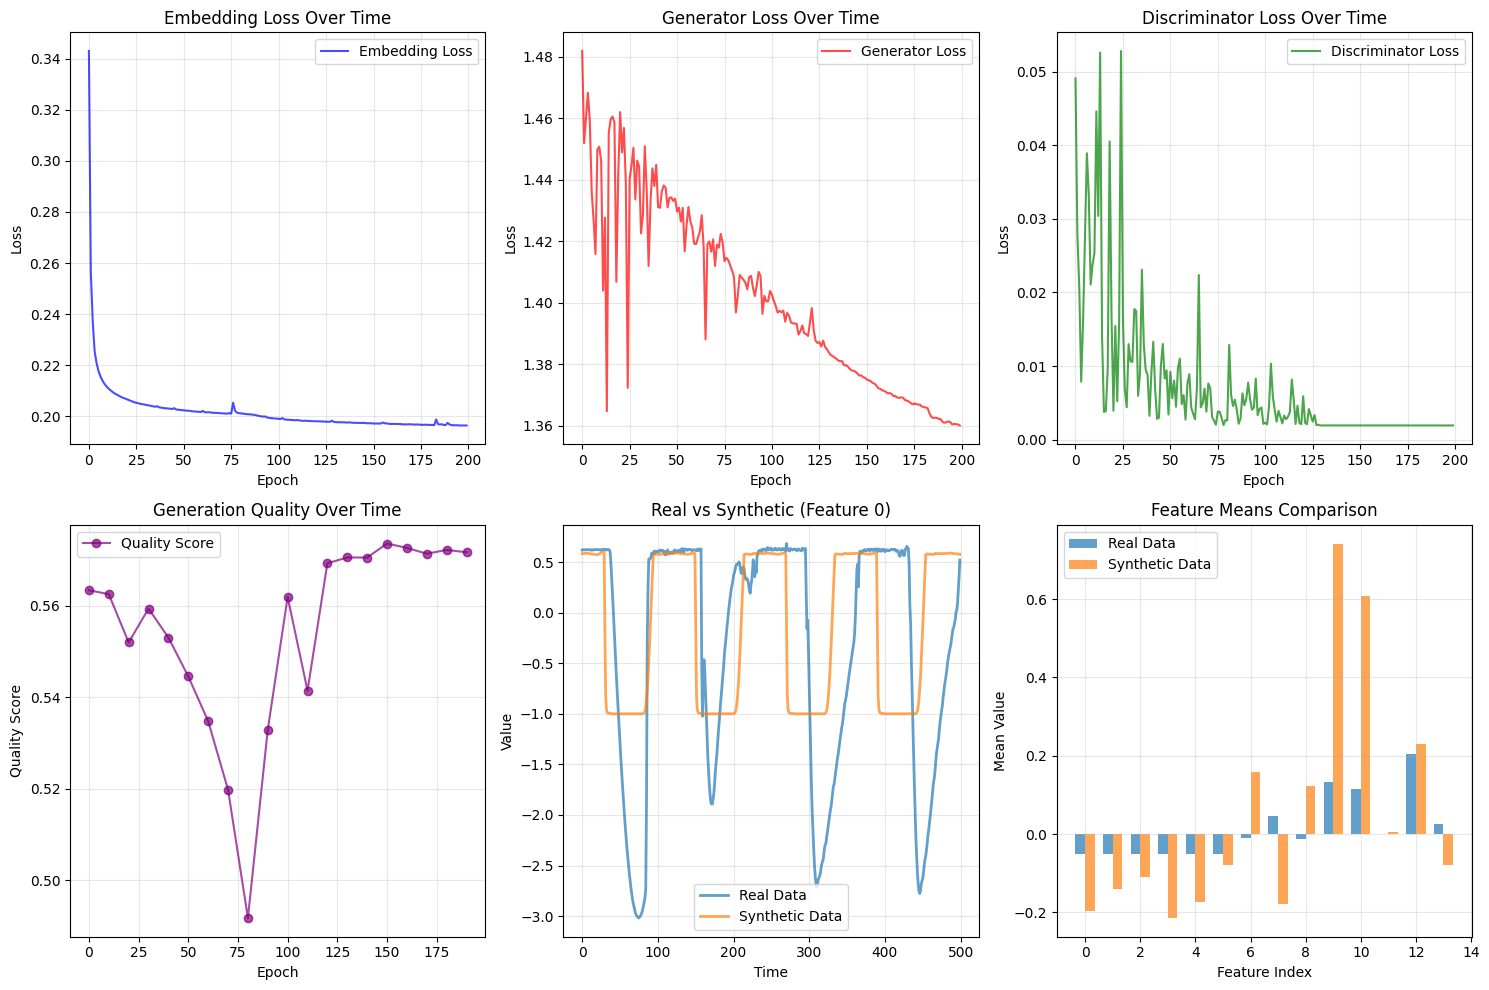

In [4]:
# Enhanced model parameters optimized for anomaly detection
chunk_size = 150  # Larger chunks for better context
input_dim = data.shape[2]  # 14 features
hidden_dim = 64  # Increased for better representation
num_layers = 3   # More layers for complex patterns
z_dim = input_dim * 2  # Larger latent space
seq_len = chunk_size
batch_size = 32  # Optimized batch size

model_params = {
    'input_dim': input_dim,
    'hidden_units': hidden_dim,  # Changed from 'hidden_dim' to 'hidden_units'
    'num_layers': num_layers,
    'z_dim': z_dim
}

train_params = {
    'epochs': 200,  # More epochs for convergence
    'learning_rate': 0.0005  # Optimized learning rate
}

print("Enhanced TimeGAN Configuration for Anomaly Detection:")
print(f"Chunk Size: {chunk_size} (better temporal context)")
print(f"Hidden Dimension: {hidden_dim} (enhanced representation)")
print(f"Number of Layers: {num_layers} (deeper networks)")
print(f"Latent Dimension: {z_dim} (richer noise space)")
print(f"Batch Size: {batch_size} (optimized for stability)")
print(f"Epochs: {train_params['epochs']} (sufficient convergence)")

# Prepare training data (use normal_data for training)
X_train_normal = normal_data

# Train the Enhanced TimeGAN model
print("\n" + "="*60)
print("STARTING ENHANCED TIMEGAN TRAINING")
print("="*60)

trained_model = train_timegan_enhanced(X_train_normal, seq_len, batch_size, model_params, train_params)

# Generate enhanced synthetic data
print("\n" + "="*60)
print("GENERATING ENHANCED SYNTHETIC DATA")
print("="*60)

num_samples = len(X_train_normal)
n_full_sequences_desired = num_samples

# Calculate chunks needed per sequence with enhanced parameters
step_size = chunk_size - 30  # overlap = 30
chunks_per_sequence = (4500 - 30) // step_size + 1
n_synthetic_chunks = n_full_sequences_desired * chunks_per_sequence

print(f"Generating {n_full_sequences_desired} full sequences:")
print(f"Chunks per sequence: {chunks_per_sequence}")
print(f"Total chunks needed: {n_synthetic_chunks}")

# Generate enhanced synthetic chunks
synthetic_chunks = generate_timegan_samples_enhanced(
    trained_model, n_synthetic_chunks, seq_len, z_dim
)
print(f"Generated {synthetic_chunks.shape} enhanced synthetic chunks")

# Reconstruct full sequences with enhanced method
synthetic_full = reconstruct_full_sequences_enhanced(
    synthetic_chunks,
    original_length=4500,
    chunk_size=chunk_size,
    overlap=30
)

print(f"Reconstructed {synthetic_full.shape} full enhanced synthetic sequences")
normal_combine = np.concatenate((X_train_normal, synthetic_full), axis=0)

# Quality Assessment
print("\n" + "="*60)
print("QUALITY ASSESSMENT")
print("="*60)

# Plot training history
if 'history' in trained_model:
    history = trained_model['history']
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Training Losses
    plt.subplot(2, 3, 1)
    plt.plot(history['embedding_loss'], label='Embedding Loss', color='blue', alpha=0.7)
    plt.title('Embedding Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 2)
    plt.plot(history['generator_loss'], label='Generator Loss', color='red', alpha=0.7)
    plt.title('Generator Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 3)
    plt.plot(history['discriminator_loss'], label='Discriminator Loss', color='green', alpha=0.7)
    plt.title('Discriminator Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Quality Scores
    if len(history['quality_scores']) > 0:
        plt.subplot(2, 3, 4)
        plt.plot(range(0, len(history['embedding_loss']), 10)[:len(history['quality_scores'])], 
                history['quality_scores'], label='Quality Score', color='purple', alpha=0.7, marker='o')
        plt.title('Generation Quality Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Quality Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Plot 3: Data Comparison
    plt.subplot(2, 3, 5)
    # Compare first feature across time for first sample
    sample_idx = 0
    feature_idx = 0
    time_points = range(min(500, X_train_normal.shape[1]))  # First 500 time points
    
    plt.plot(time_points, X_train_normal[sample_idx, time_points, feature_idx], 
            label='Real Data', alpha=0.7, linewidth=2)
    plt.plot(time_points, synthetic_full[sample_idx, time_points, feature_idx], 
            label='Synthetic Data', alpha=0.7, linewidth=2)
    plt.title(f'Real vs Synthetic (Feature {feature_idx})')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Statistical Comparison
    plt.subplot(2, 3, 6)
    real_means = np.mean(X_train_normal, axis=(0,1))
    synth_means = np.mean(synthetic_full, axis=(0,1))
    
    x_pos = np.arange(len(real_means))
    width = 0.35
    
    plt.bar(x_pos - width/2, real_means, width, label='Real Data', alpha=0.7)
    plt.bar(x_pos + width/2, synth_means, width, label='Synthetic Data', alpha=0.7)
    plt.title('Feature Means Comparison')
    plt.xlabel('Feature Index')
    plt.ylabel('Mean Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [5]:
# ===============================
# FID SCORE EVALUATION
# ===============================

# # Test the simplified FID calculation
# print("Testing simplified FID calculation...")

# # Use smaller subsets for testing
# test_real = X_train_normal[:100]  # Use 100 samples for testing
# test_generated = synthetic_full[:100]

# print(f"Test real data shape: {test_real.shape}")
# print(f"Test generated data shape: {test_generated.shape}")

# # Calculate FID score
# fid_score = calculate_fid_score(
#     real_data=test_real,
#     fake_data=test_generated,
#     device=device,
#     sample_rate=1000,
# )

# if fid_score is not None:
#     print(f"\n🎉 SUCCESS! FID Score: {fid_score:.4f}")
    
#     # Interpret the score
#     if fid_score < 10:
#         quality = "Excellent"
#     elif fid_score < 25:
#         quality = "Good"
#     elif fid_score < 50:
#         quality = "Fair"
#     elif fid_score < 100:
#         quality = "Poor"
#     else:
#         quality = "Very Poor"
    
#     print(f"Quality Assessment: {quality}")
# else:
#     print("❌ FID calculation failed. Please check the error messages above.")

In [6]:
run_pipeline_with_cv(normal_combine, X_test_normal, X_test_faulty, 
                    device=device, batch_size=64, num_epochs=20, cv_folds=5)

Extracting features from all samples...


/home/maddie/SmartIoT-2025/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maddie/SmartIoT-2025/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Starting 5-fold cross-validation...

Fold 1/5
------------------------------
Train normal samples: 110
Test samples: 35 (28 normal, 7 anomaly)


  Epoch 1/20, Loss: 0.437712


  Epoch 6/20, Loss: 0.118797


  Epoch 11/20, Loss: 0.067702


  Epoch 16/20, Loss: 0.025639


  Epoch 20/20, Loss: 0.013587


Results: Acc=0.9143, Prec=1.0000, Rec=0.5714, F1=0.7273
Optimal threshold: 0.030341

Fold 2/5
------------------------------
Train normal samples: 110
Test samples: 35 (28 normal, 7 anomaly)


  Epoch 1/20, Loss: 0.436963


  Epoch 6/20, Loss: 0.101326


  Epoch 11/20, Loss: 0.065589


  Epoch 16/20, Loss: 0.025790


  Epoch 20/20, Loss: 0.013547


Results: Acc=0.8571, Prec=1.0000, Rec=0.2857, F1=0.4444
Optimal threshold: 0.026938

Fold 3/5
------------------------------
Train normal samples: 110
Test samples: 35 (28 normal, 7 anomaly)


  Epoch 1/20, Loss: 0.437713


  Epoch 6/20, Loss: 0.117393


  Epoch 11/20, Loss: 0.070221


  Epoch 16/20, Loss: 0.029965


  Epoch 20/20, Loss: 0.013635


Results: Acc=0.9429, Prec=1.0000, Rec=0.7143, F1=0.8333
Optimal threshold: 0.026508

Fold 4/5
------------------------------
Train normal samples: 111
Test samples: 35 (27 normal, 8 anomaly)


  Epoch 1/20, Loss: 0.436970


  Epoch 6/20, Loss: 0.111301


  Epoch 11/20, Loss: 0.070452


  Epoch 16/20, Loss: 0.039433


  Epoch 20/20, Loss: 0.016108


Results: Acc=0.9143, Prec=1.0000, Rec=0.6250, F1=0.7692
Optimal threshold: 0.030225

Fold 5/5
------------------------------
Train normal samples: 111
Test samples: 35 (27 normal, 8 anomaly)


  Epoch 1/20, Loss: 0.436872


  Epoch 6/20, Loss: 0.107470


  Epoch 11/20, Loss: 0.070326


  Epoch 16/20, Loss: 0.031213


  Epoch 20/20, Loss: 0.013035


Results: Acc=0.8571, Prec=1.0000, Rec=0.3750, F1=0.5455
Optimal threshold: 0.030044

CROSS-VALIDATION RESULTS SUMMARY

FOLD-BY-FOLD RESULTS:
--------------------------------------------------------------------------------
Fold   Accuracy   Precision   Recall   F1-Score  Threshold   
--------------------------------------------------------------------------------
1      0.9143     1.0000      0.5714   0.7273    0.030341    
2      0.8571     1.0000      0.2857   0.4444    0.026938    
3      0.9429     1.0000      0.7143   0.8333    0.026508    
4      0.9143     1.0000      0.6250   0.7692    0.030225    
5      0.8571     1.0000      0.3750   0.5455    0.030044    

STATISTICAL SUMMARY:
--------------------------------------------------------------------------------
Metric       Mean     Std      Min      Max      Median  
--------------------------------------------------------------------------------
Accuracy     0.8971   0.0343   0.8571   0.9429   0.9143  
Precision    1.0000   0.0

{'fold_results': [{'fold': 1,
   'train_samples': 110,
   'test_samples': 35,
   'final_train_loss': 0.013587005397615334,
   'optimal_threshold': 0.03034061859502937,
   'accuracy': 0.9142857142857143,
   'precision': 1.0,
   'recall': 0.5714285714285714,
   'f1': 0.7272727272727273},
  {'fold': 2,
   'train_samples': 110,
   'test_samples': 35,
   'final_train_loss': 0.013546825697024664,
   'optimal_threshold': 0.026937741014843038,
   'accuracy': 0.8571428571428571,
   'precision': 1.0,
   'recall': 0.2857142857142857,
   'f1': 0.4444444444444445},
  {'fold': 3,
   'train_samples': 110,
   'test_samples': 35,
   'final_train_loss': 0.01363500242587179,
   'optimal_threshold': 0.026507866653529083,
   'accuracy': 0.9428571428571428,
   'precision': 1.0,
   'recall': 0.7142857142857143,
   'f1': 0.8333333333333333},
  {'fold': 4,
   'train_samples': 111,
   'test_samples': 35,
   'final_train_loss': 0.01610787375830114,
   'optimal_threshold': 0.03022479740056125,
   'accuracy': 0.91